In [1]:
import numpy as np
import pandas as pd
import skimage.io as io
import matplotlib.pyplot as plt
import matplotlib
import cv2
from skimage import util


from skimage.exposure import adjust_gamma

# Data description

## Experiment

 * top view   /2020-08-26 MPB14551 PE-2-WT-L-A5/Scene_0.tif
 * side view  /2020-08-26 MPB14551 PE-2-WT-L-A5/Scene_0.tif
 
 
#### Each image has two channels:
  * Dark 0
  * External 1
 
#### Microscopy settings
* Dimension (XY):	2752 x 2208
* Pixels Type:	uint16
* Pixels Size (XYZ) (µm):	12.97 x 12.97 x -
* Z-sections:	1
* Timepoints:	49

## Aim 
To find a moment of mat collapse
## Image processing pipeline
1. Isolate region of the interest
2. Cluster images
3. Check collapse


# Top view

In [2]:
top=io.imread("../2020-08-26 MPB14551 PE-2-WT-L-A5/Scene_0.tif")
top.shape

(49, 2, 2208, 2752)

In [3]:
def display(im3d,gamma,save_fig,step):
    
    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(16, 14))

    vmin = im3d.min()
    vmax = im3d.max()
    frame=0
    
    for ax, image in zip(axes.flatten(), im3d[::step]):
        ax.imshow(adjust_gamma(image,0.5), cmap="gray", vmin=vmin, vmax=vmax)
        ax.set_xticks([])
        ax.set_title(str(frame)+" frames")
        ax.set_yticks([])
        frame=frame+step
    fig.savefig("../results/for_presentation/"+save_fig,bbox_inch='tight')
    
def mask_color_img(img, mask, color=[0, 255, 255], alpha=0.3):
    '''
    img: cv2 image
    mask: bool or np.where
    color: BGR triplet [_, _, _]. Default: [0, 255, 255] is yellow.
    alpha: float [0, 1]. 

    Ref: http://www.pyimagesearch.com/2016/03/07/transparent-overlays-with-opencv/
    '''
    out=adjust_gamma(util.img_as_ubyte(img),0.3)
    out = np.dstack((out, out, out))
    img_layer = out.copy()
    img_layer[mask] = color
    out = cv2.addWeighted(img_layer, alpha, out, 1 - alpha, 0, out)
    return(out)

def plot_plane(img):
    fig,ax=plt.subplots(figsize=(10,10))
    ax.imshow(img,cmap="gray")
    
def plot_ax_plane(ax,img):
    ax.imshow(img,cmap="gray")

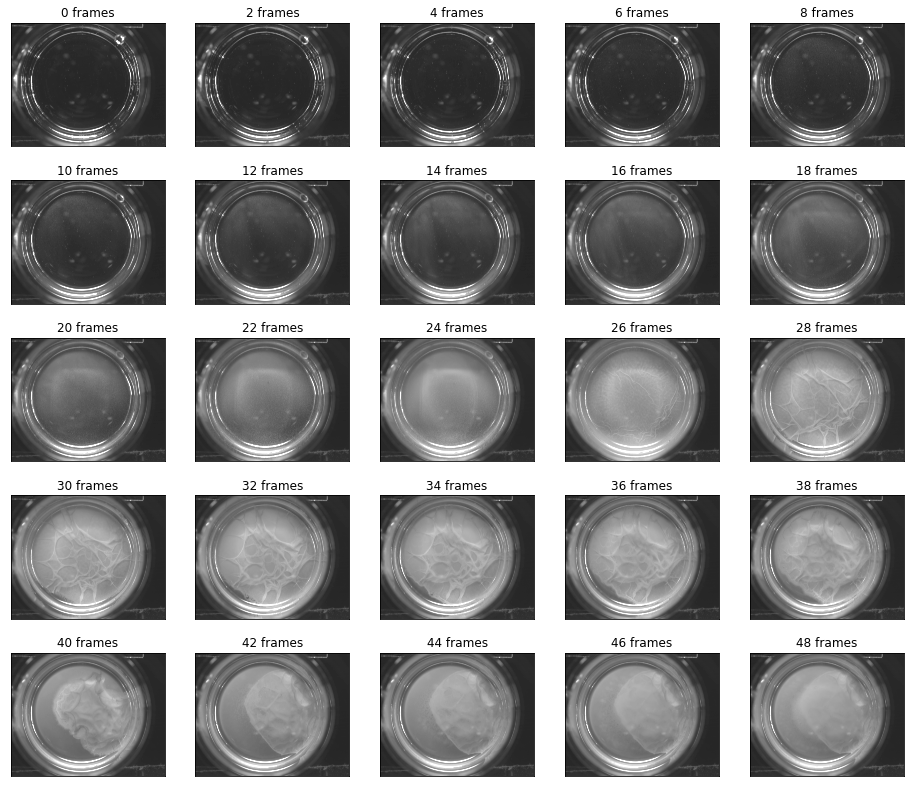

In [4]:
display(top[:,0,:,:],0.5,"top_panel.png",2)

## Segment the tube region (Hough transform)

In [5]:
img=util.img_as_ubyte(top[0,0,:,:])
img = cv2.GaussianBlur(img,(5,5),0)
edges=cv2.Canny(img,19,20)
# plot_plane(edges)


circle was found


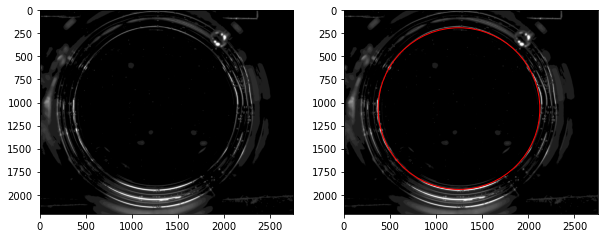

In [25]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
ax[0].imshow(adjust_gamma(img,0.5),cmap="gray")
ax[1].imshow(adjust_gamma(img,0.5),cmap="gray")

circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,100,param1=10,param2=40,minRadius=850,maxRadius=900)
if circles is not None:
    print("circle was found")
    circles = np.round(circles[0, :]).astype("int")
    
    # cicle with the most votes
    CenterX=circles[0,0]
    CenterY=circles[0,1]
    Radius= circles[0,2]
    
    circle_plot = plt.Circle((circles[0,0], circles[0,1]), circles[0,2], color='r',fill=False)
    #ax[1].scatter(x,y,marker='x')
    ax[1].add_artist(circle_plot)
        
from skimage.draw import circle,circle_perimeter
Mask=np.zeros_like(img,dtype='uint8')
rr, cc = circle(CenterY,CenterX,Radius,shape=img.shape)
Mask[rr,cc]=1
masked_img=top[24,0,:,:]*Mask;
fig.savefig("../2020-08-26 MPB14551 PE-2-WT-L-A5/results/"+"Top_Mask.png",bbox='tight')

In [7]:
### Apply mask
top_masked=np.zeros_like(top)
for frame in range(top.shape[0]):
    top_masked[frame,0,:,:]=top[frame,0,:,:]*Mask

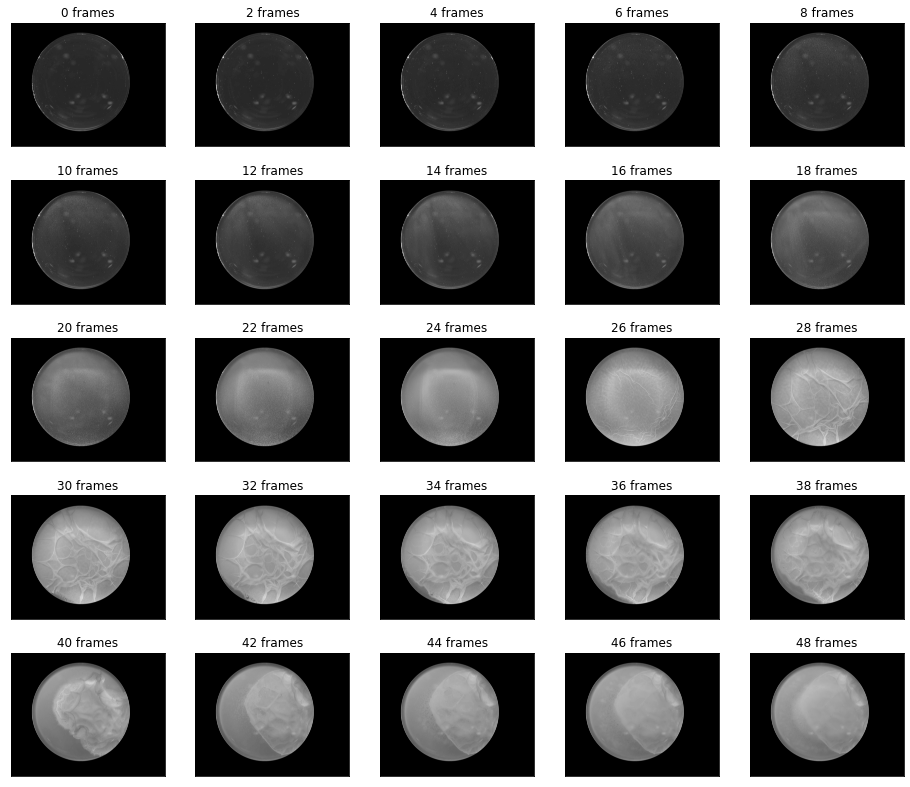

In [8]:
display(top_masked[:,0,:,:],0.5,"top_panel.png",2)

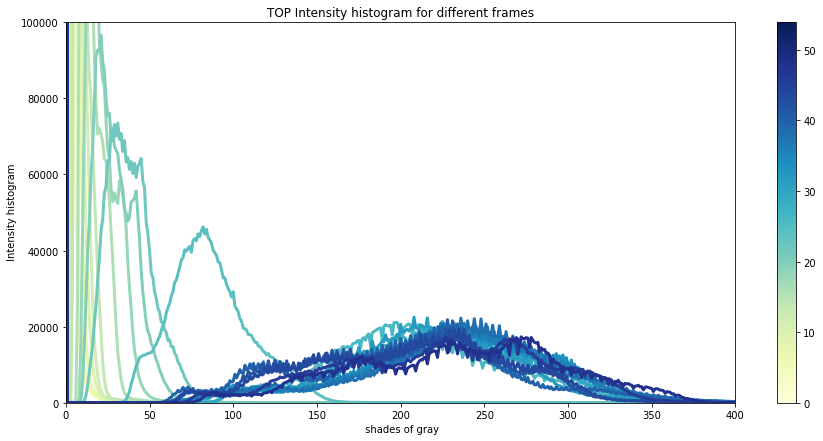

In [19]:
# Graph setup 
fig, ax = plt.subplots(1,1,figsize=(15,7))

cmap_fig=plt.get_cmap('YlGnBu')
norm = matplotlib.colors.Normalize(vmin=0, vmax=top_masked.shape[0]*1.1)
s_m = matplotlib.cm.ScalarMappable(cmap=cmap_fig, norm=norm)
s_m.set_array([])

## set the labels for each plot from the subplot
ax.set_title("TOP Intensity histogram for different frames")
ax.set_xlabel(" shades of gray")
ax.set_ylabel(" Intensity histogram")
plt.colorbar(s_m,ax=ax)


### Intensity profile
step=2
counter=0
for frame in range(0,top_masked.shape[0],step):
    hist,bins_edges=np.histogram(top_masked[frame,0,:,:].ravel(),bins=500)
    ax.plot(hist,color = cmap_fig(norm(counter)),label=str(frame),lw=3)
    counter=counter+step
    

ax.set_xlim(0,400)
ax.set_ylim(0,100000)
plt.savefig("../2020-08-26 MPB14551 PE-2-WT-L-A5/results/"+"Top_Image_hist_frame.png",bbox='tight')

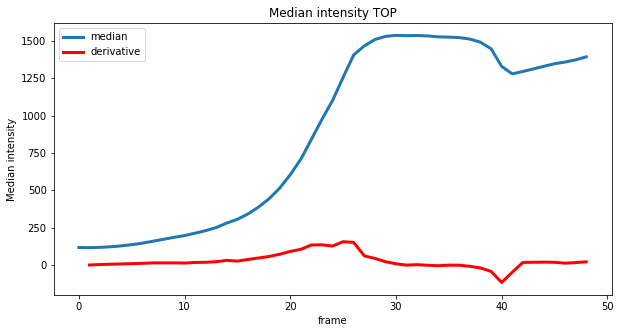

In [20]:
# Median intensity
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,5))
### Intensity profile
step=1
counter=0
img_median=[]
frames=[]
for frame in range(0,top_masked.shape[0],step):
    Median=np.median(top_masked[frame,0,top_masked[frame,0,:,:]>0])
    img_median.append(Median)
    frames.append(frame)
    
med=np.array(img_median)
Median_d=(med[1:]-med[0:-1])
frames_d=range(1,top_masked.shape[0],step)

df_med=pd.DataFrame({"frame":frames,"img_median":img_median})
ax.plot(df_med.frame,df_med.img_median,lw=3,label="median")
ax.plot(frames_d,Median_d,color='r',lw=3,label="derivative")
ax.set_title("Median intensity TOP")
ax.set_xlabel("frame")
ax.set_ylabel("Median intensity")
plt.legend()
plt.savefig("../2020-08-26 MPB14551 PE-2-WT-L-A5/results/"+"Top_Med_intensity.png",bbox='tight')

### Radial intensity

In [30]:
# import sys
# sys.path.append('../src')
# from Intensity_measurements import Translate_coord_polar,Radial_statistics

# Data_polar=Translate_coord_polar(top_masked[:,0,:,:],CenterX,CenterY)

# #Calculate radial statistics
# nlayers=100
# dr=Radius/(nlayers+1)
# Step_frame=1 
# Radial_statistics_df=Radial_statistics(Data_polar,nlayers,Radius,Step_frame,top_masked[:,0,:,:].shape[0])


# dx=12.97/1000
# dt=1
# Radial_statistics_df["time_frame"]=Radial_statistics_df["time_frame"].astype('int')
# TimeFrame=Radial_statistics_df["time_frame"].unique()# matploplib of the graph
# # Graph setup 
# fig, ax = plt.subplots(1,1,figsize=(7,7))

# cmap_fig=plt.get_cmap('viridis')
# norm = matplotlib.colors.Normalize(vmin=0, vmax=len(TimeFrame)*1.05)
# s_m = matplotlib.cm.ScalarMappable(cmap=cmap_fig, norm=norm)
# s_m.set_array([])

# ## set the labels for each plot from the subplot
# ax.set_title("Radial intensity profile ")
# ax.set_xlabel(" r distance from center mm")
# ax.set_ylabel(" Median intensity")
# plt.colorbar(s_m,ax=ax)

# #####################################################################################
# counter=0
# for i in TimeFrame:
#     data_fr=Radial_statistics_df[Radial_statistics_df["time_frame"]==i]
#     ax.plot(data_fr.r*dx,data_fr.mmedian, '-', color = cmap_fig(norm(counter)),lw=3)
#     counter=counter+1
# plt.savefig("../results/for_presentation/"+"Radial_intensity_profile.png",bbox='tight')

### Clustering

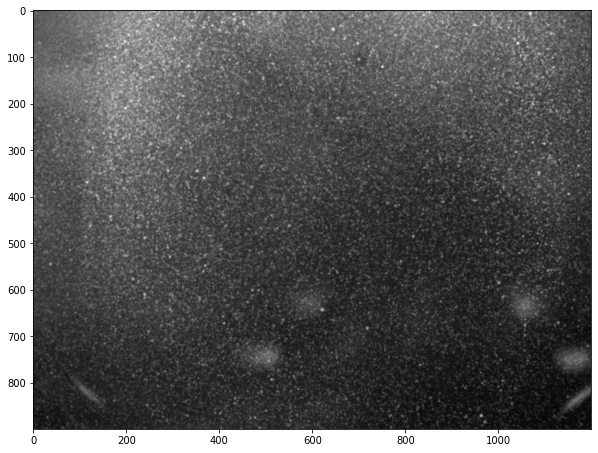

In [34]:
top_masked_uint=util.img_as_uint(top_masked)
top_masked_uint_cut=top_masked_uint[:,0,700:1600,600:1800]
plt.figure(figsize=(10,10))
plt.imshow(top_masked_uint_cut[20,:,:],cmap='gray')

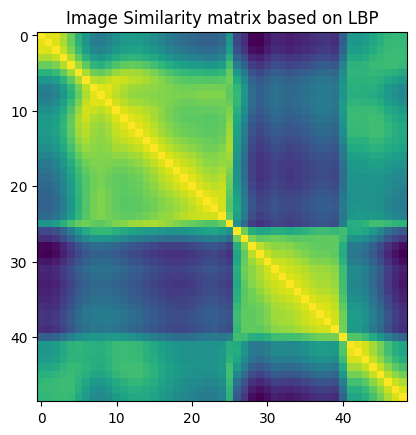

In [35]:
from skimage.feature import local_binary_pattern
from skimage.feature import local_binary_pattern
#lbp =local_binary_pattern(image=images_uint[77,:,:],P=8, R=1,method='default')

X=[]
for i in range(0,top_masked_uint.shape[0],1):
    lbp = local_binary_pattern(image=top_masked_uint_cut[i,:,:], P=8, R=5,method='default')
    n,bins=np.histogram(lbp.flatten(),bins=int(lbp.max()));
    X.append(n)


def return_intersection(hist_1, hist_2):
    minima = np.minimum(hist_1, hist_2)
    intersection = np.true_divide(np.sum(minima), np.sum(hist_2))
    return intersection

# Similarity matrix
SimilarityMatrix=np.zeros((len(X),len(X)))

for m in range(len(X)):
    for i in range(len(X)):
         SimilarityMatrix[m,i]=return_intersection(X[i], X[m])
            
plt.style.use('default')
plt.figure()
plt.imshow(SimilarityMatrix,cmap="viridis")
plt.title("Image Similarity matrix based on LBP")
plt.savefig("../results/for_presentation/"+"Image_Similarity_matrix_based_on_LBP.png",bbox='tight')

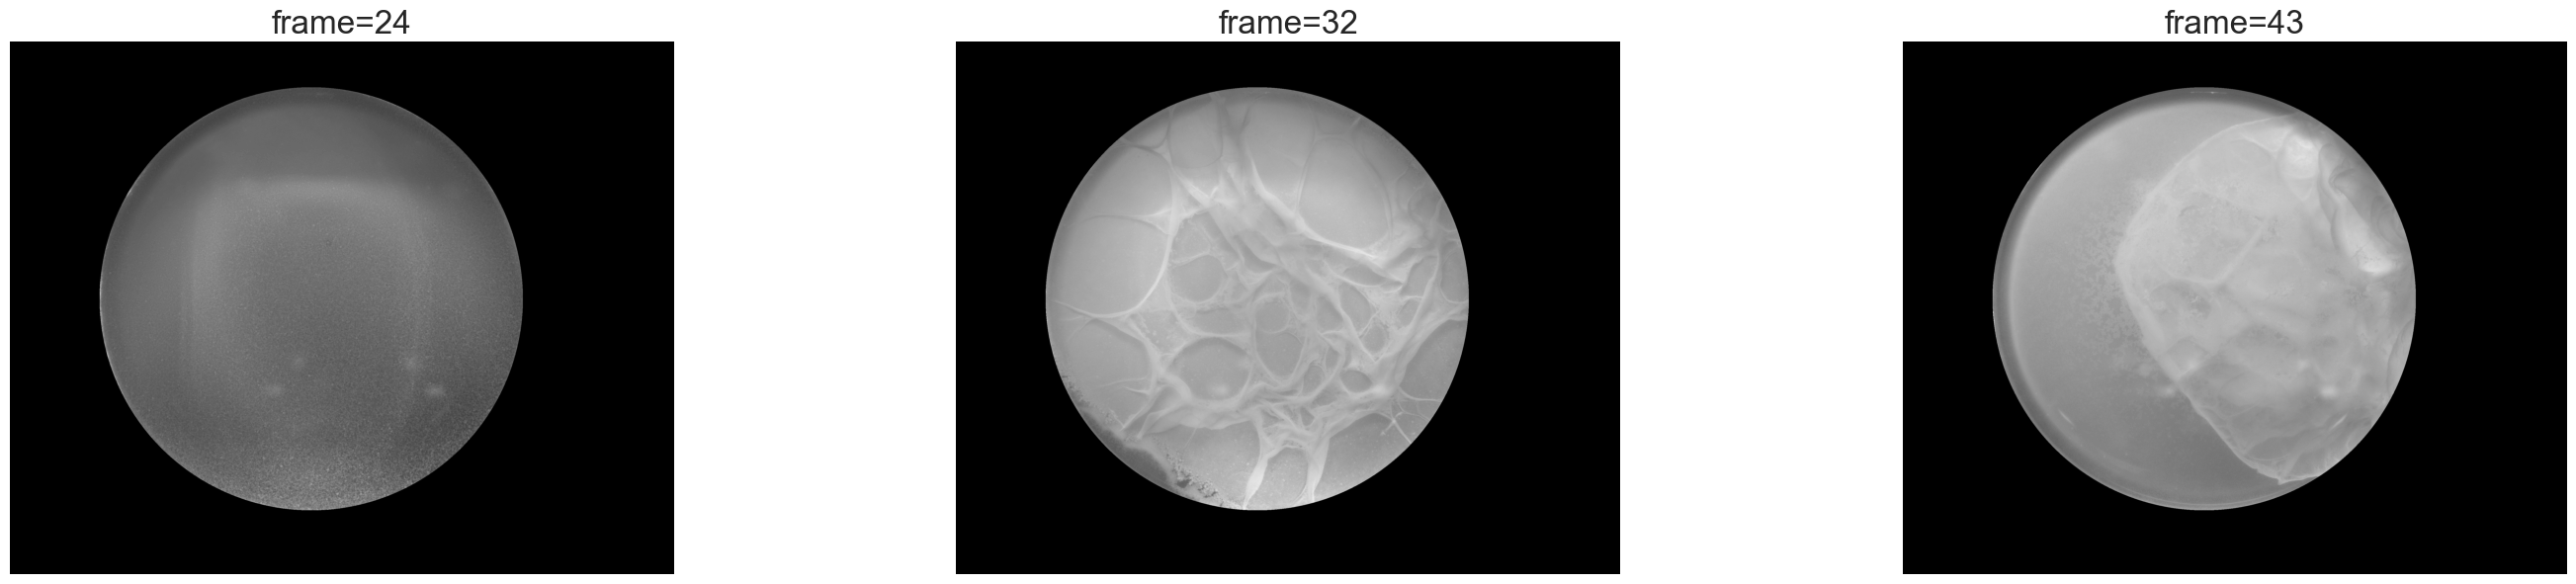

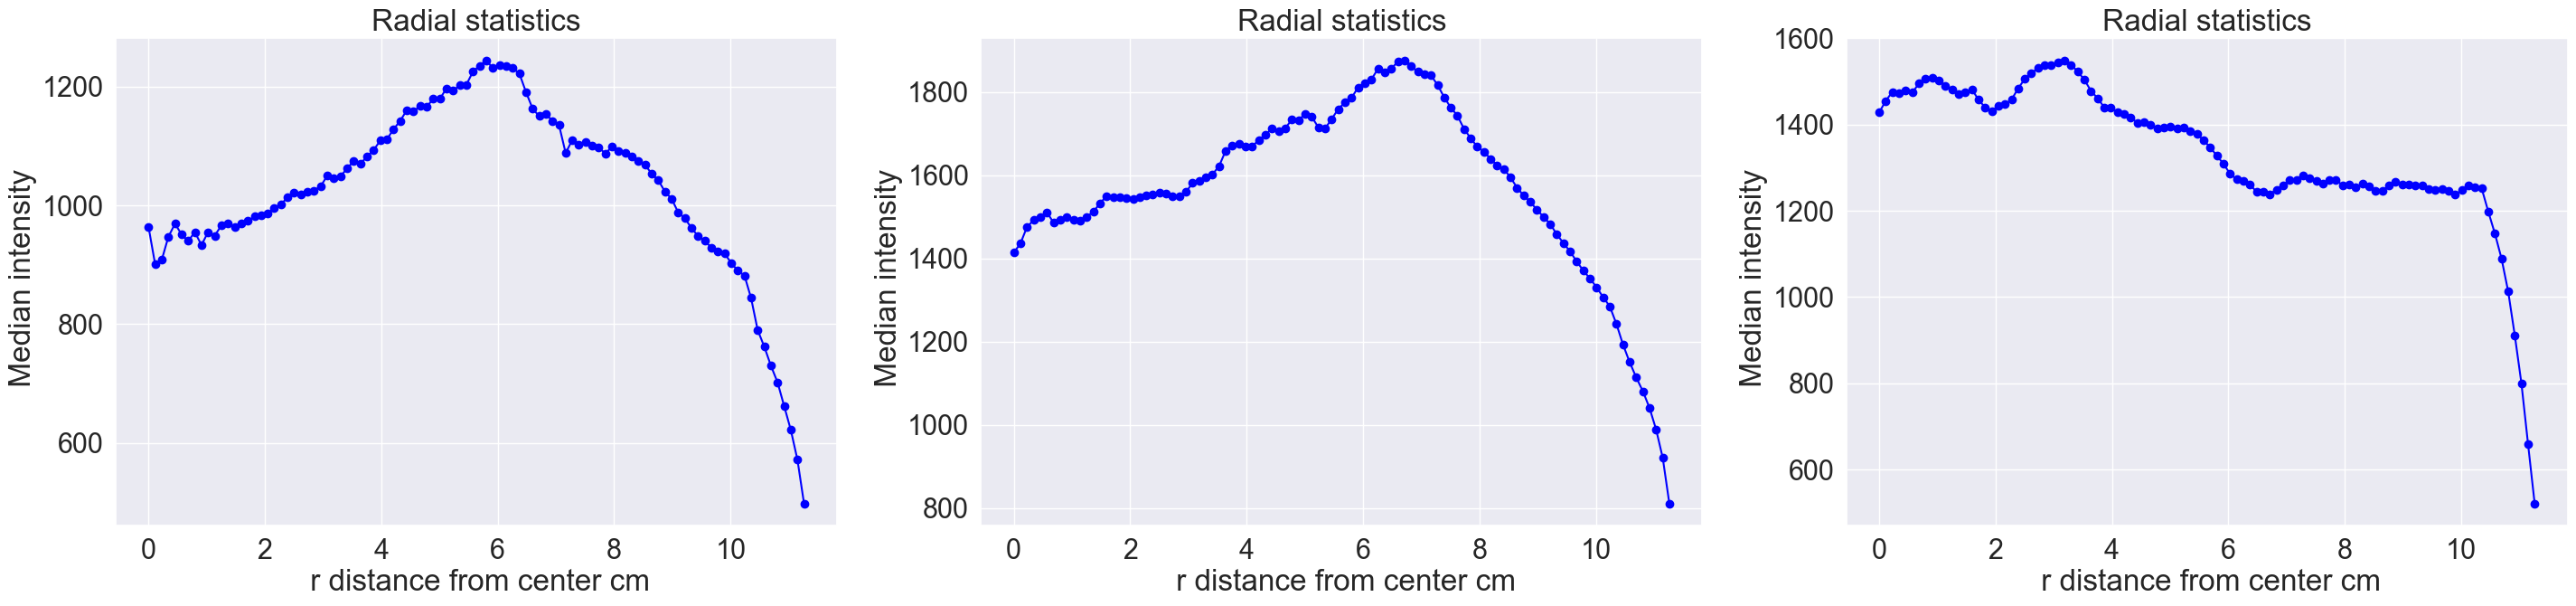

In [37]:
import seaborn as sns
sns.set_style('whitegrid')
sns.set(font_scale=2) 
fig, ax = plt.subplots(1,3,figsize=(35,7))
Time_list=[24,32,43]

for i in range(len(Time_list)):
    ax[i].imshow(adjust_gamma(top_masked[:,0,:,:][Time_list[i],:,:],0.5),cmap=plt.cm.gray)
    ax[i].set_title("frame="+str(Time_list[i]))
    ax[i].axis("off")
fig.savefig("../results/for_presentation/"+"Top_Example_of_each_cluster.png",bbox='tight')
    
fig2, ax2 = plt.subplots(1,3,figsize=(35,7))

for j in range(len(Time_list)):
    frame=Time_list[j]
    data_fr=Radial_statistics_df[Radial_statistics_df["time_frame"].astype(int)==frame]
    ax2[j].plot(data_fr.r*dx,data_fr.mmedian, '-o', color = "blue",label=str(frame))
    ax2[j].set_title("Radial statistics")
    ax2[j].set_xlabel(" r distance from center cm")
    ax2[j].set_ylabel(" Median intensity")
    #mvalue=Overall_median.loc[Overall_median["frame_number"]==frame,"mean_av"] 
    #corrected_median=data_fr.mmedian-mvalue.values[0] 
    #ax[1].plot(data_fr.r,corrected_median, '-', color = cmap_fig(norm(counter)),label=str(frame))
    counter=counter+1 
    
plt.savefig("../results/for_presentation/"+"Image_Similarity_matrix_based_on_LBP.png",bbox='tight')

# Side view

In [70]:
side=io.imread("../2020-08-26 MPB14551 PE-2-WT-L-A5/Scene_1.tif")
side_rotated=np.rot90(side,axes=(2,3))

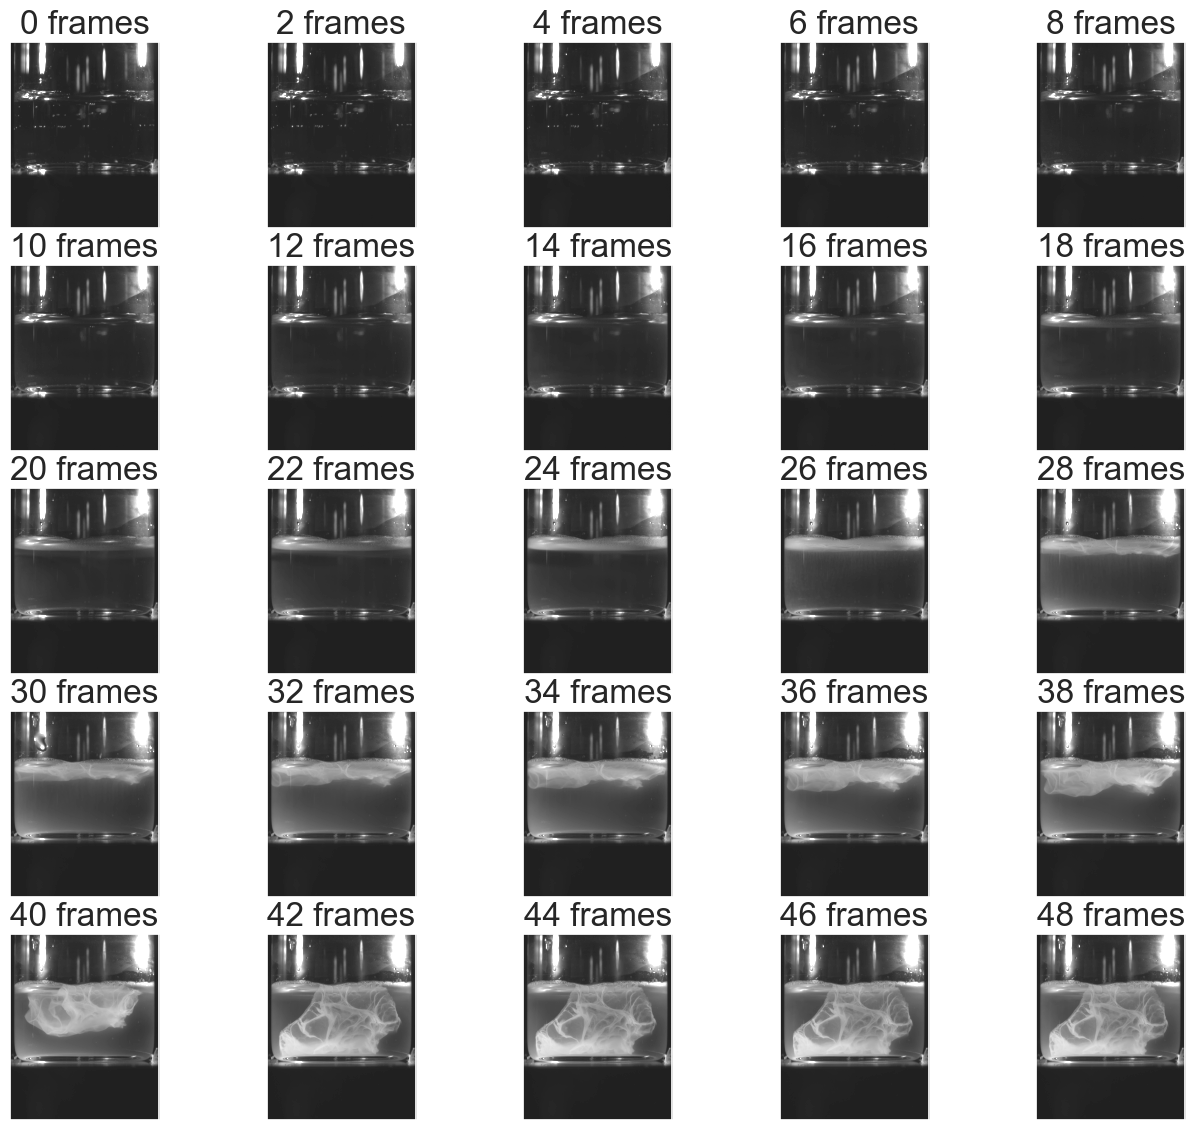

In [71]:
display(side_rotated[:,1,:,:],0.3,"side_panel.png",2)

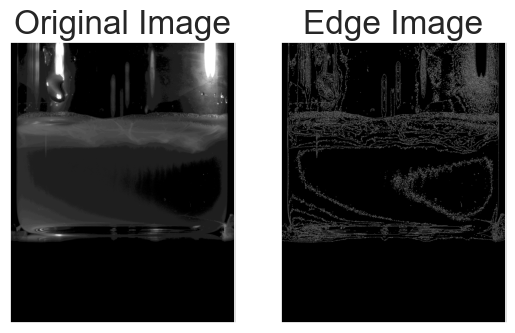

In [72]:
img=side_rotated[30,1,:,:].copy()
ii=util.img_as_ubyte(img)
edges=cv2.Canny(ii,1,5)

plt.subplot(121),plt.imshow(adjust_gamma(ii,0.5),cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([]);
plt.savefig("../results/for_presentation/"+"Side_Edge_image.png",bbox='tight')

600 1800
62 2126


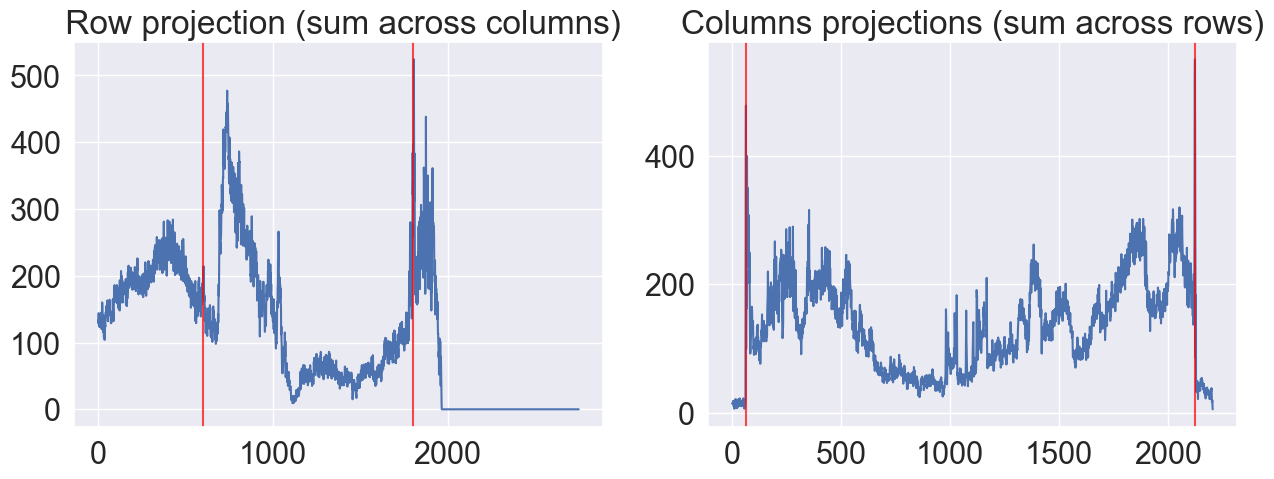

In [73]:
count_row=edges.sum(axis=1)/255
count_row_peacks=np.where(count_row>300)
min_row=600 #count_col[0][0]-100
max_row=1800 #count_col[0][-1]-100
print(min_row,max_row)

count_col=edges.sum(axis=0)/255
count_col_peacks=np.where(count_col>400)
min_col=count_col_peacks[0][0]
max_col=count_col_peacks[0][-1]
print(min_col,max_col)


fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,5))
ax[0].plot(count_row)
ax[0].axvline(x=min_row,color='red',alpha=0.7)
ax[0].axvline(x=max_row,color='red',alpha=0.7)
ax[0].set_title(" Row projection (sum across columns)") 



ax[1].plot(count_col)
ax[1].axvline(x=min_col,color='red',alpha=0.7)
ax[1].axvline(x=max_col,color='red',alpha=0.7)
ax[1].set_title("Columns projections (sum across rows)")
fig.savefig("../results/for_presentation/intensity_projection_profile.png")


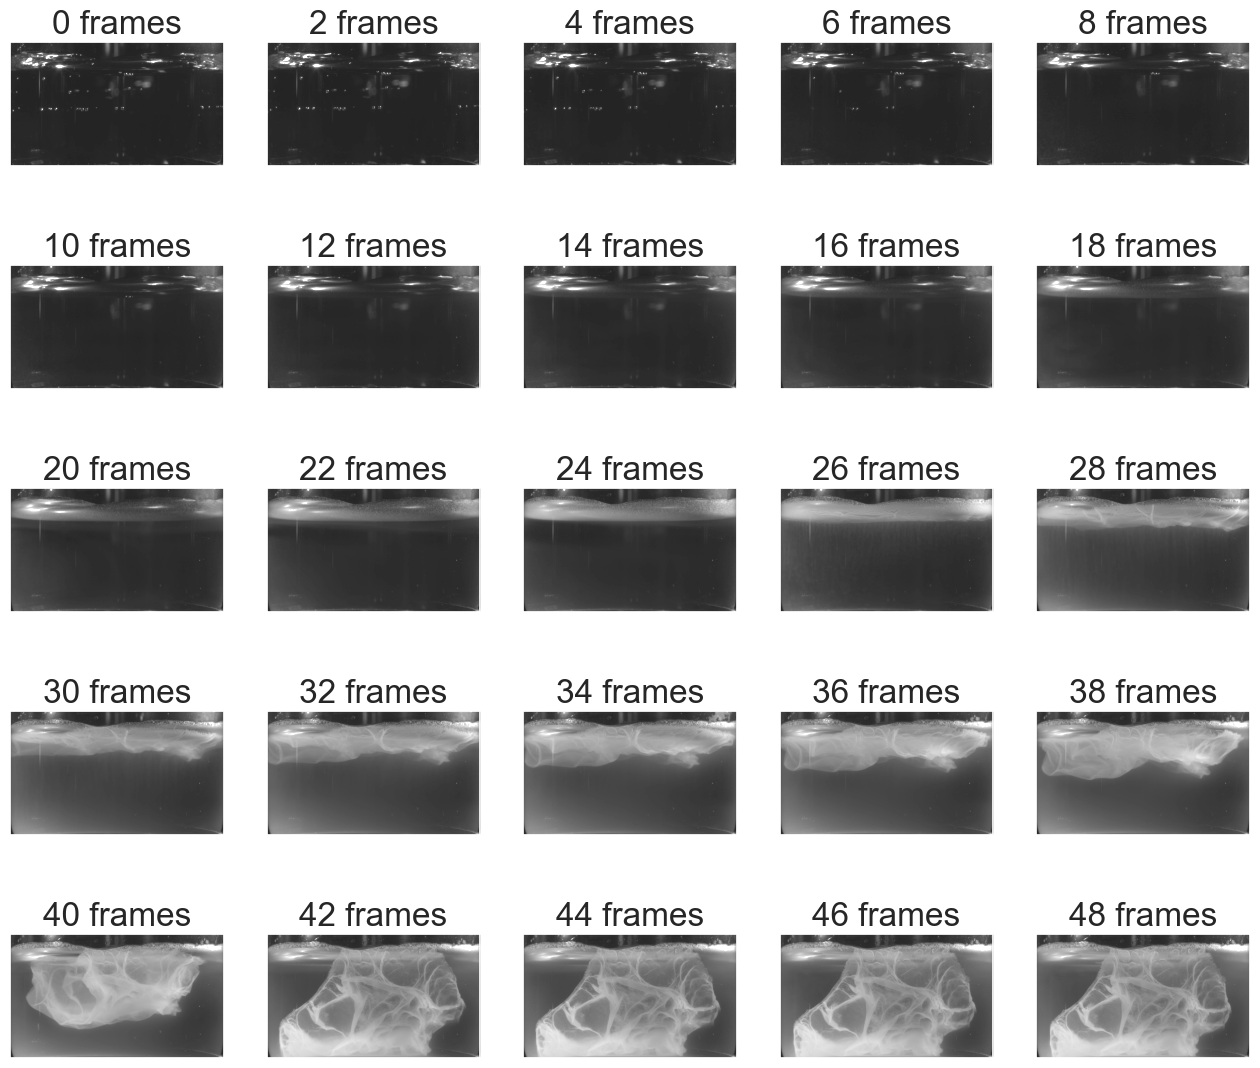

In [74]:
side_region=side_rotated[:,1,min_row:max_row,min_col:max_col].copy()

display(side_rotated[:,1,min_row:max_row,min_col:max_col],0.3,"side_panel.png",2)

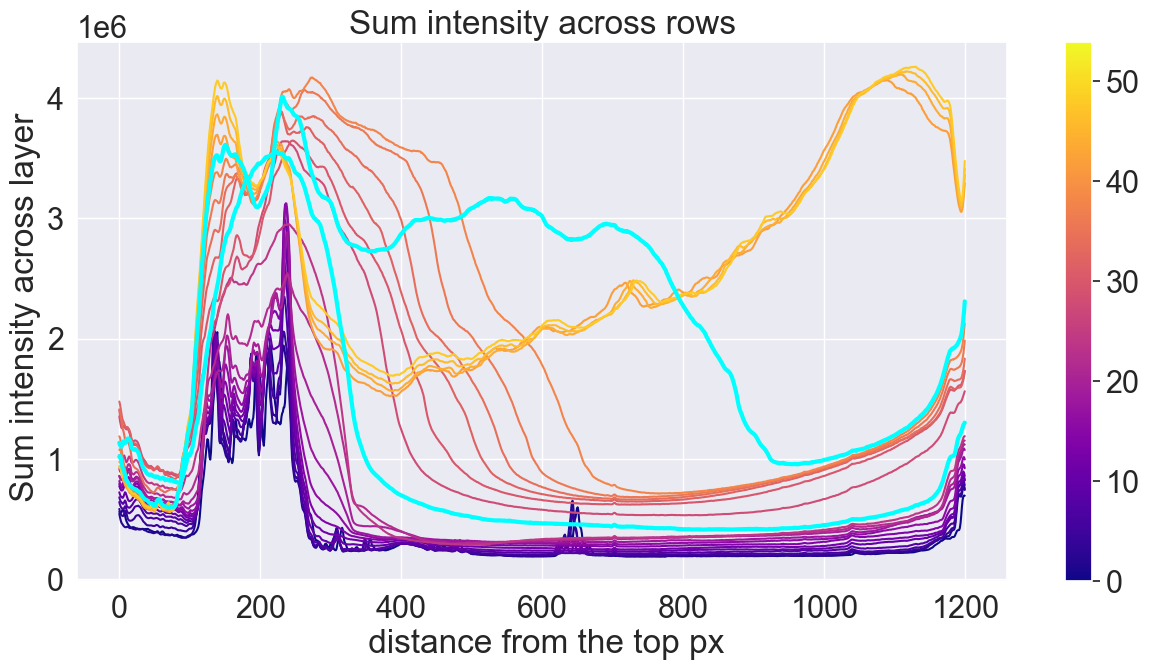

In [98]:
side_cut=side_rotated[:,1,min_row:max_row,min_col:max_col]

# Graph setup 
fig, ax = plt.subplots(1,1,figsize=(15,7))

cmap_fig=plt.get_cmap('plasma')
norm = matplotlib.colors.Normalize(vmin=0, vmax=side_cut.shape[0]*1.1)
s_m = matplotlib.cm.ScalarMappable(cmap=cmap_fig, norm=norm)
s_m.set_array([])

## set the labels for each plot from the subplot
ax.set_title("Sum intensity across rows")
ax.set_xlabel(" distance from the top px")
ax.set_ylabel(" Sum intensity across layer")
plt.colorbar(s_m,ax=ax)

#####################################################################################
counter=0
step=2
#side_cut.shape[0]
for frame in range(0,side_cut.shape[0],step):
    ax.plot(side_cut[frame].sum(axis=1), '-', color = cmap_fig(norm(counter)),label=str(frame))
    counter=counter+step
ax.plot(side_cut[26].sum(axis=1), '-', color ='cyan',lw=3)    
ax.plot(side_cut[40].sum(axis=1), '-', color ='cyan',lw=3)
plt.savefig("../results/for_presentation/"+"Side_sum_intensity_across_row_35frame.png",bbox='tight')

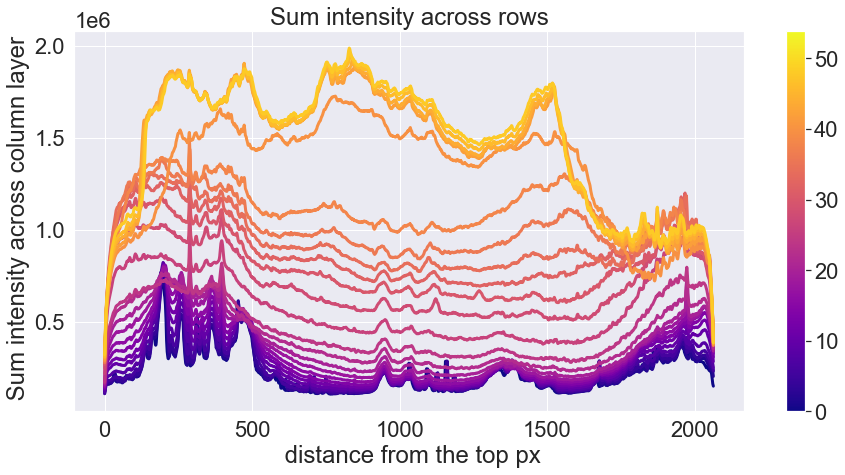

In [78]:
side_cut=side_rotated[:,1,min_row:max_row,min_col:max_col]

# Graph setup 
fig, ax = plt.subplots(1,1,figsize=(15,7))

cmap_fig=plt.get_cmap('plasma')
norm = matplotlib.colors.Normalize(vmin=0, vmax=side_cut.shape[0]*1.1)
s_m = matplotlib.cm.ScalarMappable(cmap=cmap_fig, norm=norm)
s_m.set_array([])

## set the labels for each plot from the subplot
ax.set_title("Sum intensity across rows")
ax.set_xlabel(" distance from the top px")
ax.set_ylabel(" Sum intensity across column layer")
plt.colorbar(s_m,ax=ax)

#####################################################################################
counter=0
step=2
#side_cut.shape[0]
for frame in range(0,side_cut.shape[0],step):
    ax.plot(side_cut[frame].sum(axis=0), '-', color = cmap_fig(norm(counter)),label=str(frame),lw=3)
    counter=counter+step


In [81]:
side_cut=side_rotated[:,1,min_row:max_row,600:1200].copy()
np.max(side_cut[frame,:,:])

3435

## Only for the center

In [69]:
# side_cut=side_rotated[:,1,min_row:max_row,600:1200].copy()
# side_cut=util.img_as_float(side_cut)

# # MinMax scaler
# for frame in range(0,side_cut.shape[0]):
#     Min=np.min(side_cut[frame,:,:])
#     Max=np.max(side_cut[frame,:,:])
#     side_cut[frame]=(side_cut[frame]-Min)/(Max-Min)

# # Graph setup 
# fig, ax = plt.subplots(1,1,figsize=(15,7))

# cmap_fig=plt.get_cmap('plasma')
# norm = matplotlib.colors.Normalize(vmin=0, vmax=side_cut.shape[0]*1.1)
# s_m = matplotlib.cm.ScalarMappable(cmap=cmap_fig, norm=norm)
# s_m.set_array([])

# ## set the labels for each plot from the subplot
# ax.set_title("Sum intensity across rows")
# ax.set_xlabel(" distance from the top px")
# ax.set_ylabel(" Sum intensity across layer")
# plt.colorbar(s_m,ax=ax)

# #####################################################################################
# counter=0
# step=1
# #side_cut.shape[0]
# for frame in range(0,side_cut.shape[0],step):
#     ax.plot(side_cut[frame].mean(axis=1), '-', color = cmap_fig(norm(counter)),label=str(frame),lw=3)
#     counter=counter+step

## Cluster time points
## Outsu threshold

In [95]:
from sklearn.mixture import GaussianMixture as GMM

def GMM_segmentation(img):
    ###frame,title,plot_flag=0
    # clip outliers
    #clip=np.quantile(img,0.99)
    #img[img>clip]=clip
    
    img2=img.reshape((-1,1))
    gmm_model=GMM(n_components=2,covariance_type='tied').fit(img2)
    gmm_labels=gmm_model.predict(img2)
    segmented=gmm_labels.reshape(img.shape[0],img.shape[1])
    return segmented

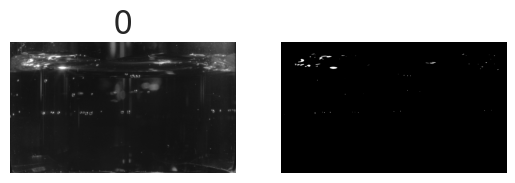

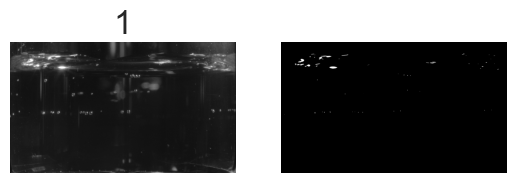

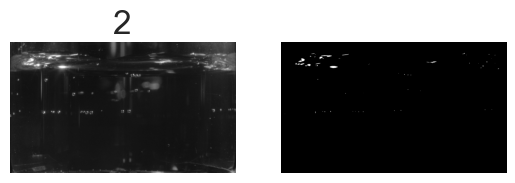

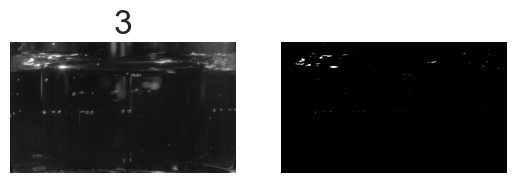

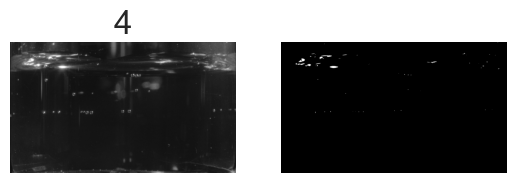

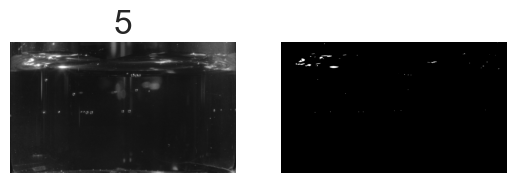

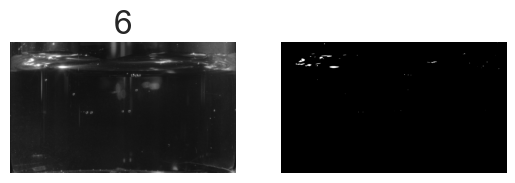

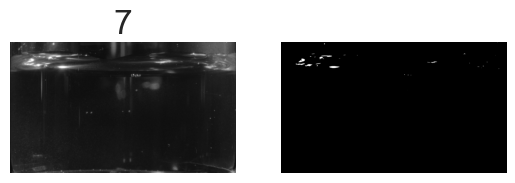

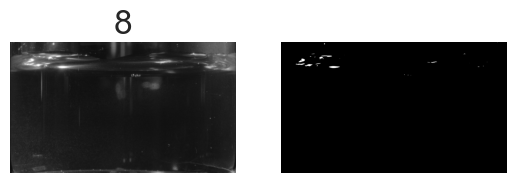

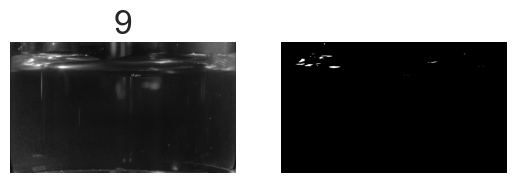

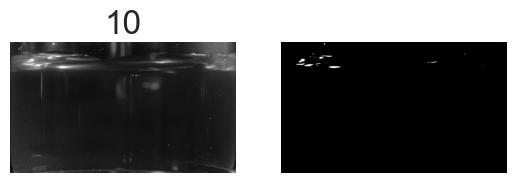

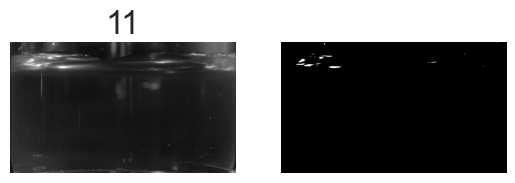

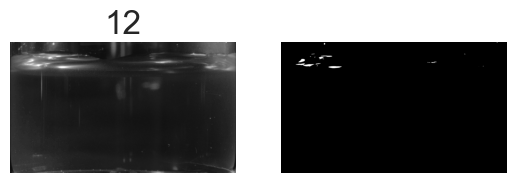

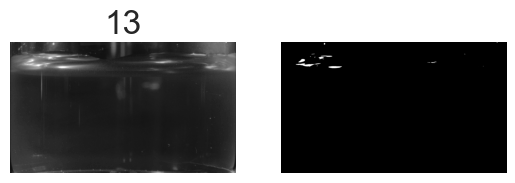

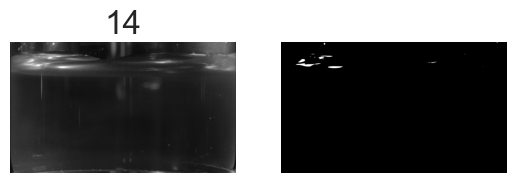

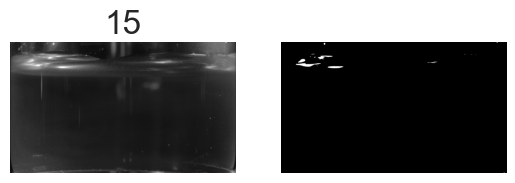

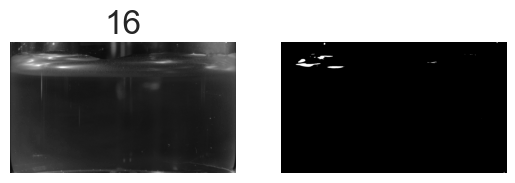

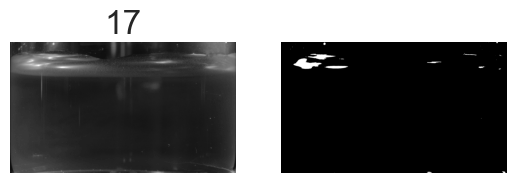

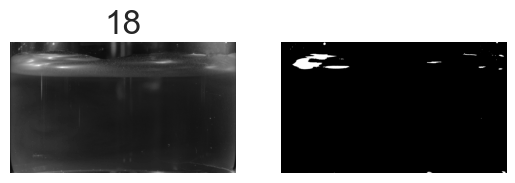

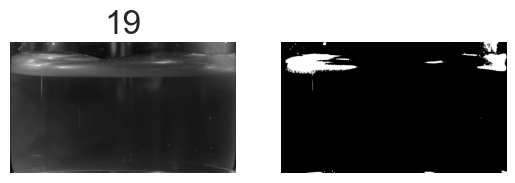

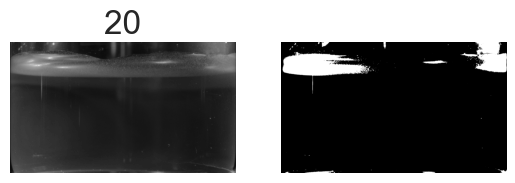

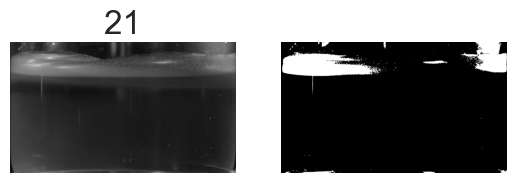

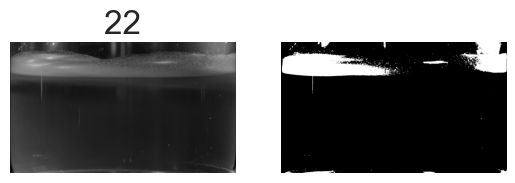

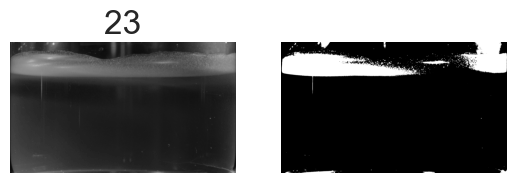

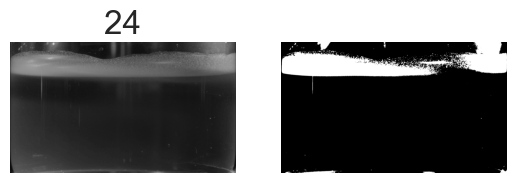

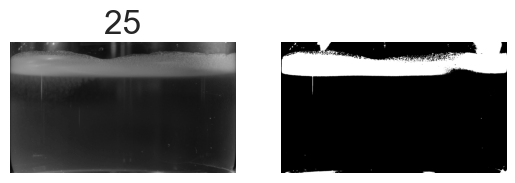

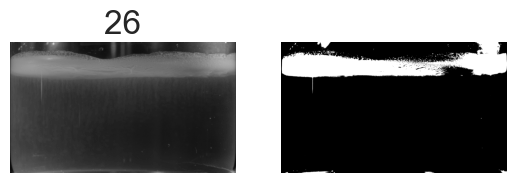

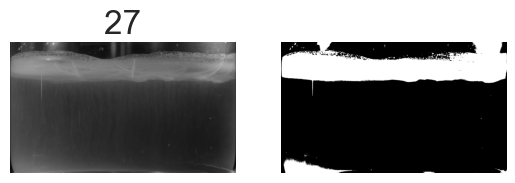

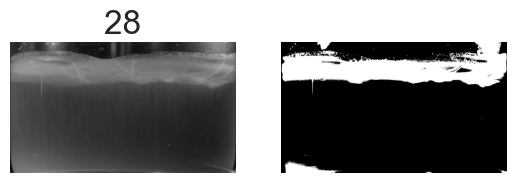

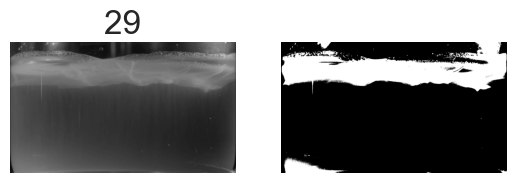

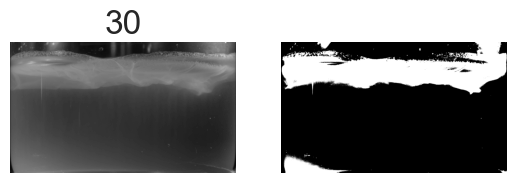

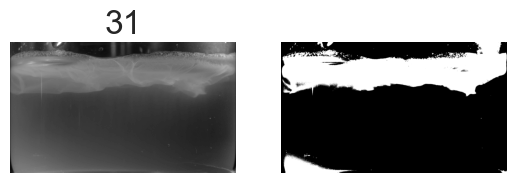

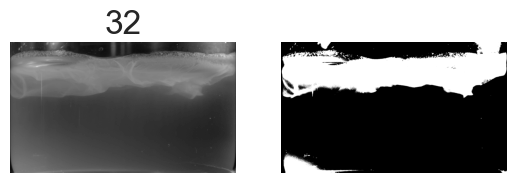

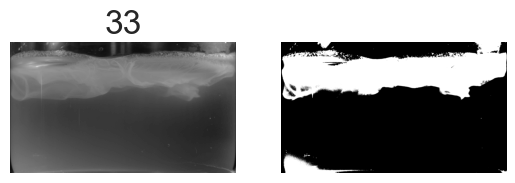

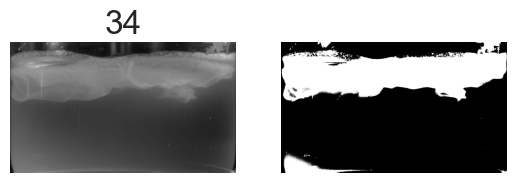

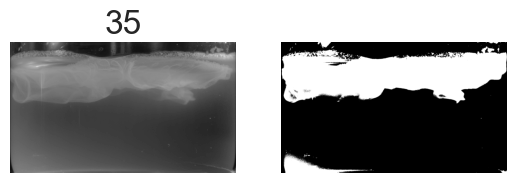

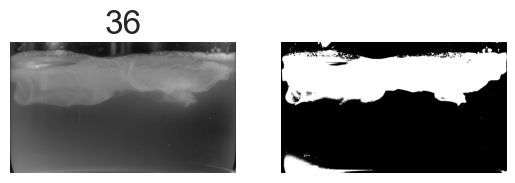

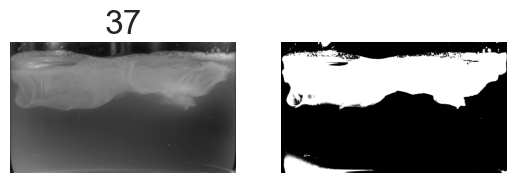

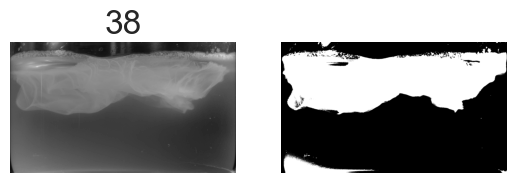

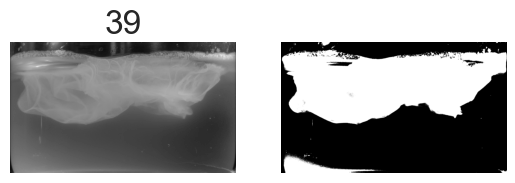

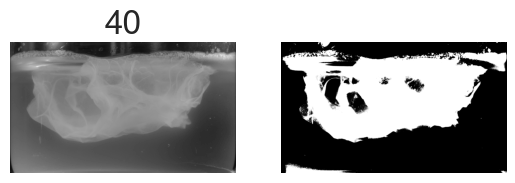

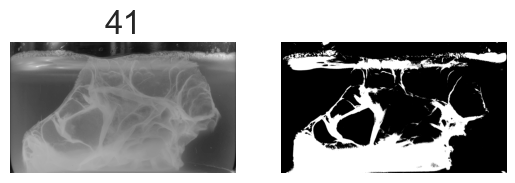

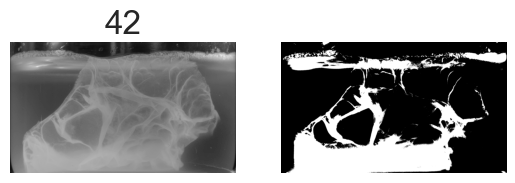

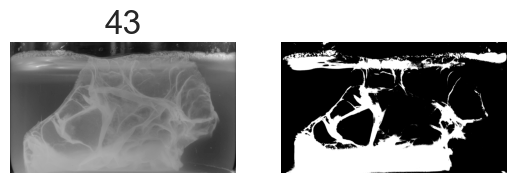

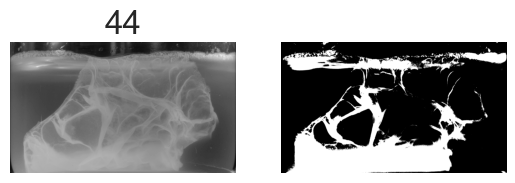

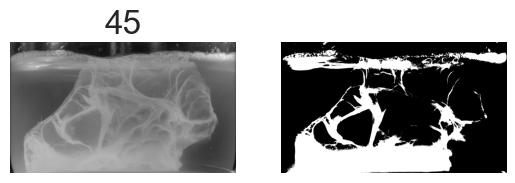

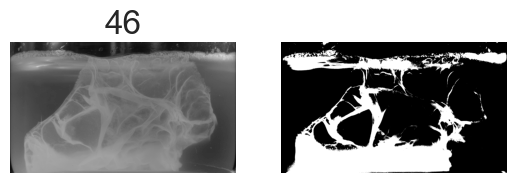

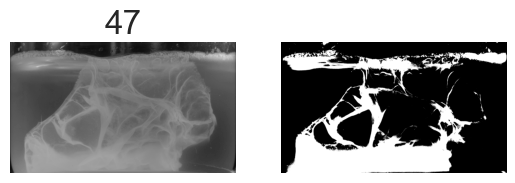

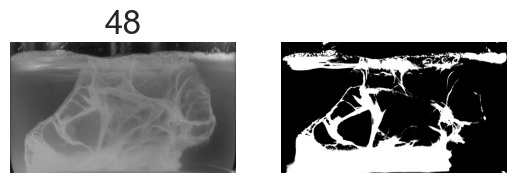

In [97]:
for frame in range(side_region.shape[0]):
    ret,th=cv2.threshold(util.img_as_ubyte(side_region[frame,:,:]),0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    #th=GMM_segmentation(side_region[frame,:,:])
    
    fig,ax=plt.subplots(nrows=1,ncols=2)
    ax[0].imshow(adjust_gamma(side_region[frame,:,:],0.1),cmap="gray")
    ax[0].axis("off")
    ax[0].set_title(str(frame))
    ax[1].imshow(th, cmap='gray')
    ax[1].axis("off")
